In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# This code is a mess
# In case you see this Mr. Papaspyrou I apologise for the state of the code
# The program doesn't exactly 'finish' but I have spent more time than
# I expected to and I have other assignments to get to. I hope you understand.

In [ ]:
# Read the CSV and parse the dates as datetime
stocks = pd.read_csv('/content/drive/MyDrive/PythonSemesterProject/stocks.csv', parse_dates=['Date'])
# Get the names and sectors of the SP500 companies which will prove useful
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0].Symbol
# Use only the SP500 companies
stocks = stocks.loc[stocks.Company_Id.isin(sp500)]
# Set the date as the index inplace
stocks.set_index(pd.DatetimeIndex(stocks['Date']), inplace=True)
# Drop the date column as it now the index
stocks.drop(columns=['Date', 'OpenInt'], inplace=True)
stocks.drop(stocks.loc[stocks.Volume == 0].index, inplace=True)
stocks['Intra'] = stocks.Close - stocks.Open
stocks.loc[stocks.Intra < 0, 'Intra'] = 0

In [ ]:
# Now we calculate the maximum number of stocks we can trade and 
# since the volume column wasn't of any other used we do it in place
stocks['Volume'] = np.floor(stocks['Volume'] * 0.1).astype(int)

In [ ]:
def buy_stock(id, when, quantity='max', mode='buy-low'):
    """
    Buys stocks and updates our wallet, our portfolio and writes an entry in our sequence.

    id: Company Id of the stocks we are buying (str)
    quantity: How many stocks we're buying (int)
    when: When we are buying the stocks (str, Timestamp)
    mode: Mode of buying can be: buy-low, buy-open, buy-close (str)
    """
    
    global current_date, wallet, portfolio, output, n_moves
   
    if type(when) is str:
        when = pd.to_datetime(when, format='%Y-%m-%d')
    
    if when < current_date:
        print('Time Paradox')

    smol = stocks.loc[(when == stocks.index) & (id == stocks.Company_Id)]

    if mode == 'buy-low':
        buy_col = smol.Low
    elif mode == 'buy-open':
        buy_col = smol.Open
    else:
        buy_col = smol.Close
    
    if quantity == 'max':
        quantity = wallet // (buy_col.item() * 1.01)
        if smol.Volume[0] < quantity:
            quantity = smol.Volume[0]
            

    # If stock exists
    if len(smol.index) == 1:
        cost = quantity * buy_col.item() * 1.01 # Define the cost of the transaction
        wallet -= cost # Remove the funds from our wallet
        portfolio[id] = quantity # Add the stock to our portfolio or update the amount
        current_date = when # Change the current date
        print('{} {} {} {}'.format(when.date(), mode, id, int(quantity)))
        output += '{} {} {} {}\n'.format(when.date(), mode, id, int(quantity))
        n_moves += 1

def sell_stock(id, when, quantity='max', mode='sell-high'):
    """
    Sells stocks and updates our wallet, our portfolio and writes an entry in our sequence.

    id: Company Id of the stocks we are selling (str)
    quantity: How many stocks we're selling (int)
    when: When we are selling the stocks (str, Timestamp)
    mode: Mode of buying can be: buy-high, buy-open, buy-close (str)
    """

    global current_date, wallet, portfolio, output, n_moves

    if type(when) is str:
        when = pd.to_datetime(when, format='%Y-%m-%d')
    
    if when < current_date:
        print('Time Paradox')

    smol = stocks.loc[(when == stocks.index) & (id == stocks.Company_Id)]

    if mode == 'sell-high':
        sell_col = smol.High
    elif mode == 'sell-open':
        sell_col = smol.Open
    else:
        sell_col = smol.Close

    if quantity == 'max':
        quantity = portfolio[id]
        if quantity > smol.Volume[0]:
            quantity = smol.Volume[0]

    gain = quantity * sell_col.item() * 0.99 # Define the gain of the transaction
    wallet += gain # Add the funds to our wallet
    portfolio[id] -= quantity # Update the stock information in our portfolio
    current_date = when # Change the current date
    print('{} {} {} {}'.format(when.date(), mode, id, int(quantity)))
    output += '{} {} {} {}\n'.format(when.date(), mode, id, int(quantity))
    n_moves += 1
    '''
    print('Sold {} {} on {} for {}'.format(quantity, id, when, gain))
    print('Wallet: {} \nPortfolio: {} \nDate: {}'
    .format(wallet, portfolio, current_date))
    print('--------------------------------------------------------')
    '''

In [ ]:
def lolipop(stock_index_stop=None):
    time_diff = 0
    if stock_index_stop is not None:
        time_diff = (stock_index_stop - current_date).days
    if (time_diff > 30 and stock_index_stop is not None) or (stock_index_stop is None):
        global n_moves, output, wallet, portfolio, year_min, year_max, init_year_offset

        profits = {}
        profits_when = {}
        time_step = 1
        # Find slice of stocks with valid date ie today and onward
        if stock_index_stop is not None:
            stock_slice = stocks.loc[(stocks.index > current_date) & (stocks.index < stock_index_stop)].sort_index()
            companies = stock_slice.loc[stock_slice.Low <= wallet].Company_Id.unique()
            time_diff = (stock_index_stop - current_date).days
            time_step = time_diff // (30*4)
            year_min = 0
            year_max = time_step*4
            if time_step == 0:
                time_step = 1
        else:
            stock_slice = stocks.loc[stocks.index > current_date].sort_index()
            companies = stock_slice.loc[(stock_slice.index <= current_date + pd.DateOffset(years=init_year_offset)) & (stock_slice.Low <= wallet)].Company_Id.unique()
        
        # For each company with stocks in the next init_year_offset years whose stocks we can afford  
        for company in companies:
            comp_profits = []
            comp = []
            # Calculate the profit for every year that we hold the stocks
            for years in range(year_min, year_max, time_step):
                sell = buy = 0
                quantity = 0
                sell_idx = buy_idx = None
                try:
                    if stock_index_stop is not None:
                        comp_slice = stock_slice.loc[(stock_slice.Company_Id == company) & (stock_slice.index <= current_date + pd.DateOffset(months=years))]
                    else:
                        comp_slice = stock_slice.loc[(stock_slice.Company_Id == company) & (stock_slice.index <= current_date + pd.DateOffset(years=years))]
                    
                    buy, buy_idx = comp_slice.Low.min(0), comp_slice.Low.idxmin(0)
                    sell, sell_idx = comp_slice.loc[comp_slice.index > buy_idx].High.max(0), comp_slice.loc[comp_slice.index > buy_idx].High.idxmax(0)
                    
                    quantity = wallet // (buy * 1.01)
                    if comp_slice.loc[comp_slice.index == buy_idx].Volume[0] < quantity:
                        quantity = comp_slice.loc[comp_slice.index == buy_idx].Volume[0]
                    if comp_slice.loc[comp_slice.index == sell_idx].Volume[0] < quantity:
                        quantity = comp_slice.loc[comp_slice.index == sell_idx].Volume[0]

                    prof = (sell - buy) * quantity / years

                    comp.append([buy_idx, sell_idx, quantity])
                    comp_profits.append(prof)
                except ValueError:
                    pass
            try:
                profits[company] = max(comp_profits)
                profits_when[company] = comp[comp_profits.index(max(comp_profits))]
            except ValueError:
                pass
        
        if len(list(profits.values())) > 0:
            if list(profits.values())[0] != -0.0:
                buy_stock(max(profits, key=profits.get), profits_when[max(profits, key=profits.get)][0], profits_when[max(profits, key=profits.get)][2])
                if wallet > 5000:
                    lolipop(stock_index_stop=profits_when[max(profits, key=profits.get)][1])
                sell_stock(max(profits, key=profits.get), profits_when[max(profits, key=profits.get)][1], profits_when[max(profits, key=profits.get)][2])
            else:
                print(n_moves)
                output = str(n_moves) + '\n' + output
                with open('large.txt', 'w') as f:
                    f.write(output)
                raise ProgramFinished

In [ ]:
n_moves = 0
output = ''
wallet = 1 # Our wallet which starts at 1$
portfolio = {} # Our portfolio which starts out empty
current_date = pd.to_datetime('1960-01-01', format='%Y-%m-%d') # The date we're on

while n_moves <= 1000000:
    year_min = 2
    year_max = 5
    init_year_offset = 3
    lolipop()

In [ ]:
wallet = 1
portfolio = {}
current_date = pd.to_datetime('1960-01-01', format='%Y-%m-%d')

wallet_history = [1]
pf_val_history = [0]
date_index = [current_date]

with open('large.txt', 'r') as f:
    for i, line in enumerate(f):
        if i == 0:
            continue
        splt = line.split(' ')
        current_date = pd.to_datetime(splt[0], format='%Y-%m-%d')
        mode = splt[1]
        comp = splt[2]
        quant = int(splt[3])

        if mode == 'buy-low':
            p = stocks.loc[(stocks.Company_Id == comp) & (stocks.index == current_date)].Low[0]
            price = p*quant
            wallet -= price
            try:
                portfolio[comp] += quant
            except KeyError:
                portfolio[comp] = 0
                portfolio[comp] += quant
        else:
            p = stocks.loc[(stocks.Company_Id == comp) & (stocks.index == current_date)].High[0]
            price = p*quant
            wallet += price
            portfolio[comp] -= quant
        
        wallet_history.append(wallet)
        date_index.append(current_date)
        pf_val = 0
        for stock in portfolio.items():
            id = stock[0]
            q = stock[1]
            p = stocks.loc[(stocks.Company_Id == id) & (stocks.index == current_date)].Close[0]
            pf_val += q*p
        pf_val_history.append(pf_val)

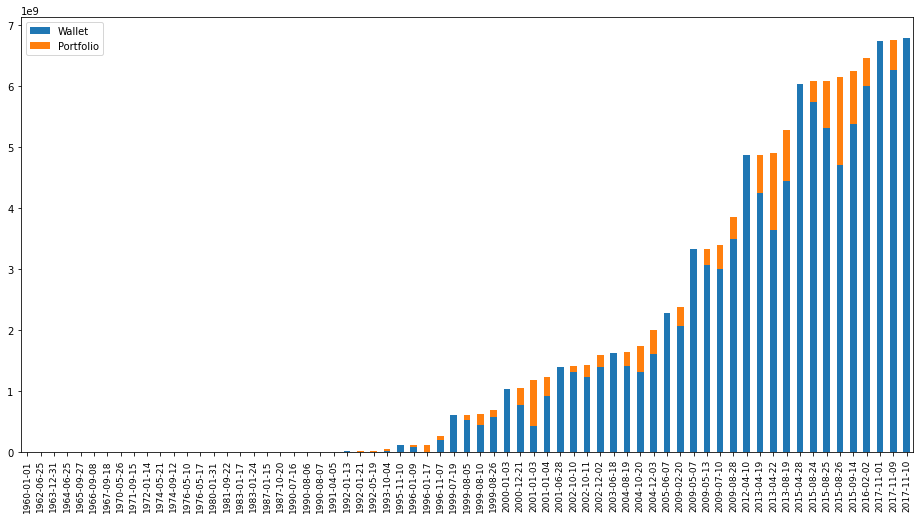

In [ ]:
df = pd.DataFrame(list(zip(date_index, wallet_history, pf_val_history)), columns=['Date', 'Wallet', 'Portfolio'])
df.set_index(pd.DatetimeIndex(df['Date']), inplace=True)
df.drop(columns=['Date'], inplace=True)
df.index = df.index.date
df.plot(kind='bar', stacked=True, figsize=(16,8))
plt.tick_params(axis='x', which='major', labelsize=9)